# NYC Taxi Fare Prediction

## Setup

In [867]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
sns.set_palette('muted')
pal = sns.color_palette().as_hex()
from scipy.stats import pearsonr

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

import osmnx as ox
import networkx as nx
import igraph as ig
import folium
from string import ascii_uppercase
from itertools import product
from time import sleep

### Importing Data

In [868]:
taxi = pd.read_csv('train_prev.csv')        # Truncated preview
# taxi = pd.read_csv('train.csv', nrows=1000000)

## Inspection

In [869]:
taxi.head(20)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1
5,2011-01-06 09:50:45.0000002,12.1,2011-01-06 09:50:45 UTC,-74.000964,40.731630,-73.972892,40.758233,1
6,2012-11-20 20:35:00.0000001,7.5,2012-11-20 20:35:00 UTC,-73.980002,40.751662,-73.973802,40.764842,1
7,2012-01-04 17:22:00.00000081,16.5,2012-01-04 17:22:00 UTC,-73.951300,40.774138,-73.990095,40.751048,1
8,2012-12-03 13:10:00.000000125,9.0,2012-12-03 13:10:00 UTC,-74.006462,40.726713,-73.993078,40.731628,1
9,2009-09-02 01:11:00.00000083,8.9,2009-09-02 01:11:00 UTC,-73.980658,40.733873,-73.991540,40.758138,2


In [870]:
taxi.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,11.354652,-72.494682,39.914481,-72.490967,39.919053,1.673820
std,9.716777,10.693934,6.225686,10.471386,6.213427,1.300171
min,-44.900000,-736.550000,-74.007670,-84.654241,-74.006377,0.000000
25%,6.000000,-73.992041,40.734996,-73.991215,40.734182,1.000000
50%,8.500000,-73.981789,40.752765,-73.980000,40.753243,1.000000
75%,12.500000,-73.966982,40.767258,-73.963433,40.768166,2.000000
max,200.000000,40.787575,401.083332,40.851027,404.616667,6.000000


In [871]:
taxi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   key                100000 non-null  object 
 1   fare_amount        100000 non-null  float64
 2   pickup_datetime    100000 non-null  object 
 3   pickup_longitude   100000 non-null  float64
 4   pickup_latitude    100000 non-null  float64
 5   dropoff_longitude  100000 non-null  float64
 6   dropoff_latitude   100000 non-null  float64
 7   passenger_count    100000 non-null  int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 6.1+ MB


## Cleaning

### Pickup Datetime

In [872]:
taxi['pickup_datetime'] = pd.to_datetime(taxi['pickup_datetime'])
taxi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   key                100000 non-null  object             
 1   fare_amount        100000 non-null  float64            
 2   pickup_datetime    100000 non-null  datetime64[ns, UTC]
 3   pickup_longitude   100000 non-null  float64            
 4   pickup_latitude    100000 non-null  float64            
 5   dropoff_longitude  100000 non-null  float64            
 6   dropoff_latitude   100000 non-null  float64            
 7   passenger_count    100000 non-null  int64              
dtypes: datetime64[ns, UTC](1), float64(5), int64(1), object(1)
memory usage: 6.1+ MB


### NaN Values

In [873]:
taxi.dropna(subset=['dropoff_longitude', 'dropoff_latitude'], inplace=True)
taxi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   key                100000 non-null  object             
 1   fare_amount        100000 non-null  float64            
 2   pickup_datetime    100000 non-null  datetime64[ns, UTC]
 3   pickup_longitude   100000 non-null  float64            
 4   pickup_latitude    100000 non-null  float64            
 5   dropoff_longitude  100000 non-null  float64            
 6   dropoff_latitude   100000 non-null  float64            
 7   passenger_count    100000 non-null  int64              
dtypes: datetime64[ns, UTC](1), float64(5), int64(1), object(1)
memory usage: 6.1+ MB


### Fare Amount

<Axes: xlabel='fare_amount'>

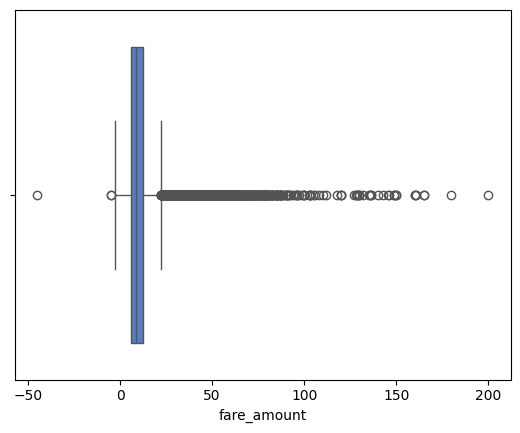

In [874]:
sns.boxplot(data=taxi, x='fare_amount')

In [875]:
# len(taxi.loc[~taxi['fare_amount'].between(0, 200)])
taxi = taxi.loc[taxi['fare_amount'].between(0, 200)]
taxi.info()

<class 'pandas.core.frame.DataFrame'>
Index: 99991 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   key                99991 non-null  object             
 1   fare_amount        99991 non-null  float64            
 2   pickup_datetime    99991 non-null  datetime64[ns, UTC]
 3   pickup_longitude   99991 non-null  float64            
 4   pickup_latitude    99991 non-null  float64            
 5   dropoff_longitude  99991 non-null  float64            
 6   dropoff_latitude   99991 non-null  float64            
 7   passenger_count    99991 non-null  int64              
dtypes: datetime64[ns, UTC](1), float64(5), int64(1), object(1)
memory usage: 6.9+ MB


### Coordinate Boundaries

In [876]:
longitude_bound = (-74.3, -73.5)    # -74.3, -73.5
latitude_bound = (40.5, 41.0)       # 40.5, 41.0

#### Pickup Longitude

<Axes: xlabel='pickup_longitude'>

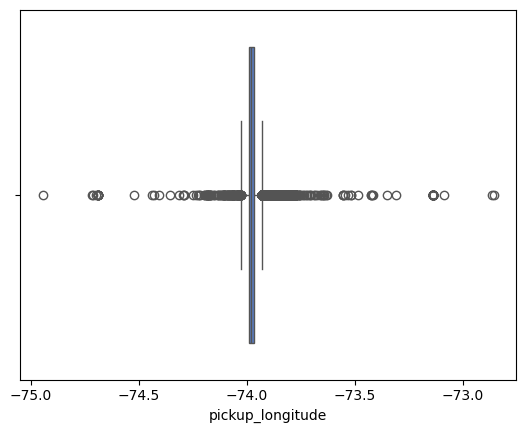

In [877]:
sns.boxplot(data=taxi.loc[taxi['pickup_longitude'].between(-75.0, -72.0)], x='pickup_longitude')

In [878]:
# len(taxi.loc[~taxi['pickup_longitude'].between(*longitude_bound)])
taxi = taxi.loc[taxi['pickup_longitude'].between(*longitude_bound)]
taxi.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,97932.000000,97932.000000,97932.000000,97932.000000,97932.000000,97932.000000
mean,11.334829,-73.975346,40.754049,-73.910342,40.724694,1.674458
std,9.633352,0.035008,1.168463,2.169374,1.609876,1.300601
min,0.000000,-74.295537,0.783332,-84.654241,-2.269701,0.000000
25%,6.000000,-73.992264,40.736637,-73.991387,40.735685,1.000000
50%,8.500000,-73.982077,40.753523,-73.980425,40.753933,1.000000
75%,12.500000,-73.968315,40.767650,-73.965075,40.768459,2.000000
max,200.000000,-73.515952,401.083332,0.000000,404.616667,6.000000


#### Pickup Latitude

<Axes: xlabel='pickup_latitude'>

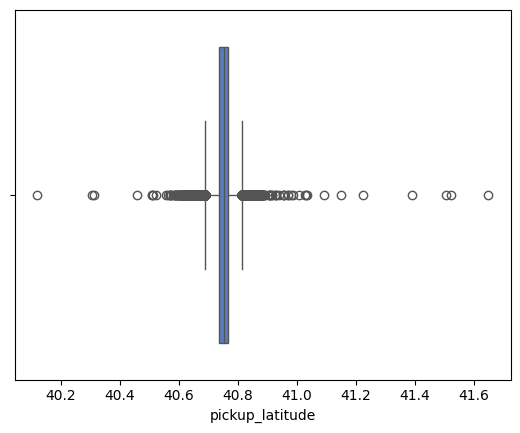

In [879]:
sns.boxplot(data=taxi.loc[taxi['pickup_latitude'].between(40.0, 42.0)], x='pickup_latitude')

In [880]:
# len(taxi.loc[~taxi['pickup_latitude'].between(*latitude_bound)])
taxi = taxi.loc[taxi['pickup_latitude'].between(*latitude_bound)]
taxi.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,97898.000000,97898.000000,97898.000000,97898.000000,97898.000000,97898.000000
mean,11.329369,-73.975375,40.750925,-73.910356,40.724673,1.674508
std,9.582558,0.034851,0.027059,2.169748,1.610107,1.300571
min,0.000000,-74.295537,40.509960,-84.654241,-2.269701,0.000000
25%,6.000000,-73.992265,40.736652,-73.991387,40.735684,1.000000
50%,8.500000,-73.982079,40.753523,-73.980428,40.753932,1.000000
75%,12.500000,-73.968324,40.767648,-73.965092,40.768452,2.000000
max,165.000000,-73.518402,40.988240,0.000000,404.616667,6.000000


#### Dropoff Longitude

<Axes: xlabel='dropoff_longitude'>

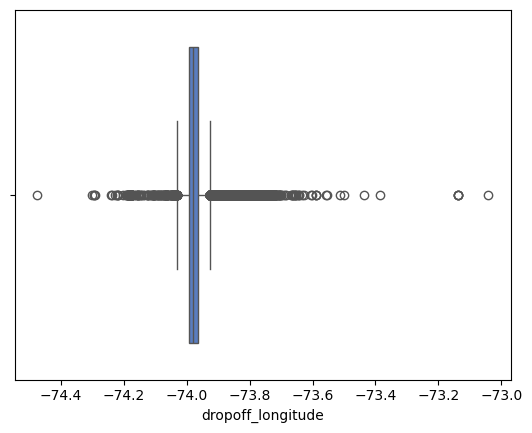

In [881]:
sns.boxplot(data=taxi.loc[taxi['dropoff_longitude'].between(-75.0, -72.0)], x='dropoff_longitude')

In [882]:
# len(taxi.loc[~taxi['dropoff_longitude'].between(*longitude_bound)])
taxi = taxi.loc[taxi['dropoff_longitude'].between(*longitude_bound)]
taxi.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,97802.000000,97802.000000,97802.000000,97802.000000,97802.000000,97802.000000
mean,11.325426,-73.975394,40.750928,-73.974230,40.754650,1.674506
std,9.558649,0.034774,0.027042,0.034695,1.170955,1.300450
min,0.000000,-74.295537,40.509960,-74.294613,0.728087,0.000000
25%,6.000000,-73.992267,40.736652,-73.991397,40.735758,1.000000
50%,8.500000,-73.982084,40.753524,-73.980442,40.753952,1.000000
75%,12.500000,-73.968330,40.767650,-73.965164,40.768463,2.000000
max,165.000000,-73.518402,40.988240,-73.513693,404.616667,6.000000


#### Dropoff Latitude

<Axes: xlabel='dropoff_latitude'>

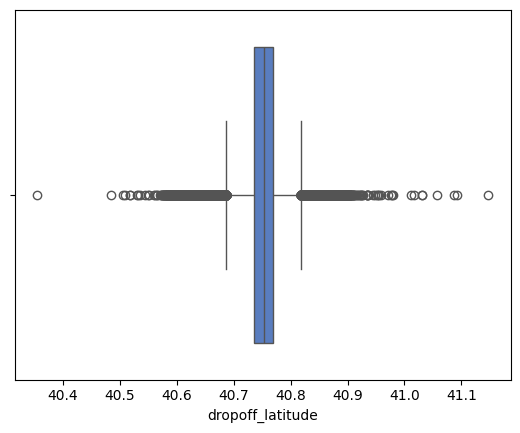

In [883]:
sns.boxplot(data=taxi.loc[taxi['dropoff_latitude'].between(40.0, 42.0)], x='dropoff_latitude')

In [884]:
# len(taxi.loc[~taxi['dropoff_latitude'].between(*latitude_bound)])
taxi = taxi.loc[taxi['dropoff_latitude'].between(*latitude_bound)]
taxi.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,97786.000000,97786.000000,97786.000000,97786.000000,97786.000000,97786.000000
mean,11.318773,-73.975399,40.750928,-73.974239,40.751366,1.674534
std,9.520177,0.034761,0.027025,0.034663,0.030938,1.300484
min,0.000000,-74.295537,40.509960,-74.294613,40.505648,0.000000
25%,6.000000,-73.992267,40.736653,-73.991397,40.735763,1.000000
50%,8.500000,-73.982084,40.753523,-73.980443,40.753952,1.000000
75%,12.500000,-73.968332,40.767648,-73.965172,40.768455,2.000000
max,165.000000,-73.518402,40.988240,-73.513693,40.979617,6.000000


### Exact Same Pickup and Dropoff

In [885]:
taxi = taxi.loc[~((taxi['pickup_longitude'] == taxi['dropoff_longitude']) | (taxi['pickup_latitude'] == taxi['dropoff_latitude']))]

In [886]:
taxi.info()

<class 'pandas.core.frame.DataFrame'>
Index: 96703 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   key                96703 non-null  object             
 1   fare_amount        96703 non-null  float64            
 2   pickup_datetime    96703 non-null  datetime64[ns, UTC]
 3   pickup_longitude   96703 non-null  float64            
 4   pickup_latitude    96703 non-null  float64            
 5   dropoff_longitude  96703 non-null  float64            
 6   dropoff_latitude   96703 non-null  float64            
 7   passenger_count    96703 non-null  int64              
dtypes: datetime64[ns, UTC](1), float64(5), int64(1), object(1)
memory usage: 6.6+ MB


### Passenger Count

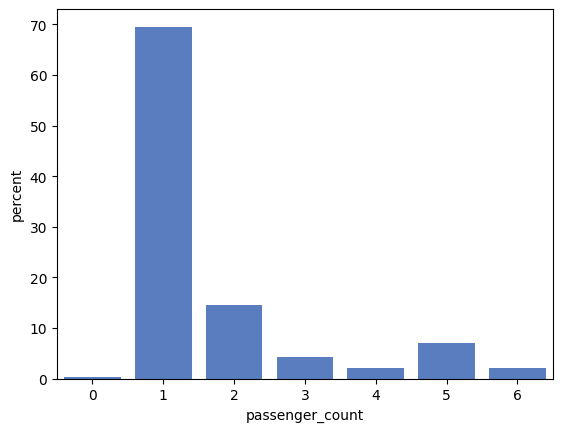

In [887]:
passenger_plt = sns.countplot(data=taxi, x='passenger_count', stat='percent')

In [888]:
# len(taxi.loc[taxi['passenger_count'] == 0])
taxi = taxi.loc[taxi['passenger_count'] != 0]
taxi.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,96346.000000,96346.000000,96346.000000,96346.000000,96346.000000,96346.000000
mean,11.327455,-73.975552,40.750963,-73.974392,40.751409,1.681045
std,9.442060,0.034423,0.026834,0.034308,0.030799,1.299071
min,0.000000,-74.295537,40.509960,-74.294613,40.505648,1.000000
25%,6.000000,-73.992287,40.736685,-73.991407,40.735779,1.000000
50%,8.500000,-73.982105,40.753535,-73.980469,40.753974,1.000000
75%,12.500000,-73.968466,40.767662,-73.965347,40.768473,2.000000
max,165.000000,-73.518402,40.988240,-73.513693,40.978090,6.000000


###

In [889]:
taxi.reset_index(drop=True, inplace=True)

In [890]:
taxi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96346 entries, 0 to 96345
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   key                96346 non-null  object             
 1   fare_amount        96346 non-null  float64            
 2   pickup_datetime    96346 non-null  datetime64[ns, UTC]
 3   pickup_longitude   96346 non-null  float64            
 4   pickup_latitude    96346 non-null  float64            
 5   dropoff_longitude  96346 non-null  float64            
 6   dropoff_latitude   96346 non-null  float64            
 7   passenger_count    96346 non-null  int64              
dtypes: datetime64[ns, UTC](1), float64(5), int64(1), object(1)
memory usage: 5.9+ MB


## Feature Engineering

### Distance

In [891]:
def haversine(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    
    km = 6371 * c
    return km

def distance_km(df):
    return haversine(df['pickup_latitude'], df['pickup_longitude'], df['dropoff_latitude'], df['dropoff_longitude'])

taxi['distance_km'] = distance_km(taxi)

### Time

In [892]:
def hour(df):
    return (df['pickup_datetime'].dt.hour).astype('category')
def dayofweek(df):
    dow =  df['pickup_datetime'].dt.dayofweek
    dow = dow.replace({0:'Mon', 1:'Tue', 2:'Wed', 3:'Thu', 4:'Fri', 5:'Sat', 6:'Sun'})
    return pd.Categorical(dow, categories=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], ordered=True)
def month(df):
    return (df['pickup_datetime'].dt.month).astype('category')
def year(df):
    return (df['pickup_datetime'].dt.year).astype('category')
def nighttime(df):
    return ((df['pickup_datetime'].dt.hour) >= 20) | ((df['pickup_datetime'].dt.hour) <= 5)

taxi['hour'] = hour(taxi)
taxi['dayofweek'] = dayofweek(taxi)
taxi['month'] = month(taxi)
taxi['year'] = year(taxi)
taxi['nighttime'] = nighttime(taxi)

### Passengers

In [893]:
def multiple_passengers(df):
    return np.where(df['passenger_count'] > 1, True, False)

taxi['multiple_passengers'] = multiple_passengers(taxi)

### Location

In [894]:
n_clusters = 32
n_init = 4
kmeans_pickup_loc = KMeans(n_clusters=n_clusters, n_init=n_init, random_state=1)
kmeans_dropoff_loc = KMeans(n_clusters=n_clusters, n_init=n_init, random_state=1)
kmeans_distance_loc = KMeans(n_clusters=n_clusters, n_init=n_init, random_state=1)

def cluster(model, features, fit):
    if fit: model.fit(features)
    letters = [''.join(p) for p in product(ascii_uppercase, repeat=2)][:n_clusters]
    clust_name_dict = {i:f'cluster_{c}' for i,c in enumerate(letters)}
    clusters = pd.Series(model.predict(features)).replace(clust_name_dict)
    return pd.Categorical(clusters, categories=clust_name_dict.values(), ordered=True)

def pickup_loc(df, fit=False):
    return cluster(kmeans_pickup_loc, df[['pickup_longitude', 'pickup_latitude']], fit=fit)
def dropoff_loc(df, fit=False):
    return cluster(kmeans_dropoff_loc, df[['dropoff_longitude', 'dropoff_latitude']], fit=fit)
def distance_loc(df, fit=False):
    return cluster(kmeans_distance_loc, df[['distance_km', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']], fit=fit)

taxi['pickup_loc'] = pickup_loc(taxi, fit=True)
taxi['dropoff_loc'] = dropoff_loc(taxi, fit=True)
# taxi['distance_loc'] = distance_loc(taxi, fit=True)

In [895]:
print(taxi['fare_amount'].mean(), end='\n\n')
df = pd.DataFrame({'mean': taxi.groupby(['pickup_loc', 'dropoff_loc'])['fare_amount'].mean(), 'count': taxi.groupby(['pickup_loc', 'dropoff_loc'])['fare_amount'].count(), 'mean_diff': taxi.groupby(['pickup_loc', 'dropoff_loc'])['fare_amount'].mean() - taxi['fare_amount'].mean()}).sort_values('count', ascending=False)
df.head(50)

11.327454694538433



C:\Users\Alex\AppData\Local\Temp\ipykernel_19220\4045830882.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df = pd.DataFrame({'mean': taxi.groupby(['pickup_loc', 'dropoff_loc'])['fare_amount'].mean(), 'count': taxi.groupby(['pickup_loc', 'dropoff_loc'])['fare_amount'].count(), 'mean_diff': taxi.groupby(['pickup_loc', 'dropoff_loc'])['fare_amount'].mean() - taxi['fare_amount'].mean()}).sort_values('count', ascending=False)


mean  count  mean_diff
pickup_loc dropoff_loc                            
cluster_AV cluster_AB   6.148774    995  -5.178681
           cluster_BA   6.545506    939  -4.781949
cluster_AZ cluster_AN   7.159327    817  -4.168128
cluster_AA cluster_AK   6.206679    816  -5.120776
cluster_AV cluster_AK   5.754837    769  -5.572617
cluster_AN cluster_AW   7.272069    759  -4.055386
cluster_AR cluster_BA   5.511563    755  -5.815892
cluster_AM cluster_AK   6.391816    749  -4.935639
cluster_AA cluster_AW   7.719705    745  -3.607750
cluster_AS cluster_AW   6.295822    718  -5.031633
cluster_AM cluster_AB   5.352340    705  -5.975114
cluster_AZ cluster_BA   7.157675    671  -4.169780
cluster_AS cluster_AN   5.904858    671  -5.422596
cluster_AA cluster_AQ   6.806716    670  -4.520738
cluster_AV cluster_AN   6.892793    666  -4.434662
cluster_AM cluster_AU   6.347604    647  -4.979850
cluster_AQ cluster_AU   5.078091    639  -6.249364
cluster_AZ cluster_AW   6.155665    639  -5.171790
cluster_AA cluster_BA   5.848978    636  -5.478477
cluster_AV cluster_AW   9.455189    636  -1.872266
cluster_AP cluster_AJ   7.237235    633  -4.090219
cluster_AV cluster_AU   8.283365    633  -3.044090
cluster_AX cluster_AA   5.828149    632  -5.499306
cluster_AF cluster_AW   6.645146    618  -4.682309
cluster_AR cluster_AK   7.421769    616  -3.905685
cluster_AQ cluster_AK   7.856494    616  -3.470961
           cluster_AB   5.669771    612  -5.657683
cluster_AR cluster_AQ   5.360920    609  -5.966535
cluster_AE cluster_AL   5.427183    607  -5.900272
cluster_AN cluster_AN   5.948067    600  -5.379388
cluster_AP cluster_BD   6.610253    592  -4.717201
cluster_AA cluster_AN   7.177399    592  -4.150056
cluster_BB cluster_AI   6.313644    590  -5.013811
cluster_AZ cluster_AQ   6.374711    588  -4.952744
cluster_AC cluster_AI   6.359673    581  -4.967782
cluster_AN cluster_AD   5.903026    575  -5.424429
cluster_AK cluster_AA   5.719930    574  -5.607524
cluster_AF cluster_AI   6.308798    574  -5.018657
cluster_AR cluster_AW   7.432810    573  -3.894645
cluster_AC cluster_AJ   5.748161    560  -5.579294
           cluster_AQ   7.118247    559  -4.209208
cluster_AV cluster_AQ   8.883925    558  -2.443530
cluster_AX cluster_AJ   6.173140    551  -5.154315
cluster_BB cluster_AQ   5.804080    549  -5.523375
cluster_AS cluster_AK   7.420183    545  -3.907271
cluster_AD cluster_AU   5.478821    543  -5.848633
cluster_BB cluster_AW   7.663401    541  -3.664054
           cluster_AJ   6.832220    536  -4.495235
cluster_AK cluster_AQ   6.274906    530  -5.052549
cluster_AN cluster_AK   7.055009    529  -4.272445

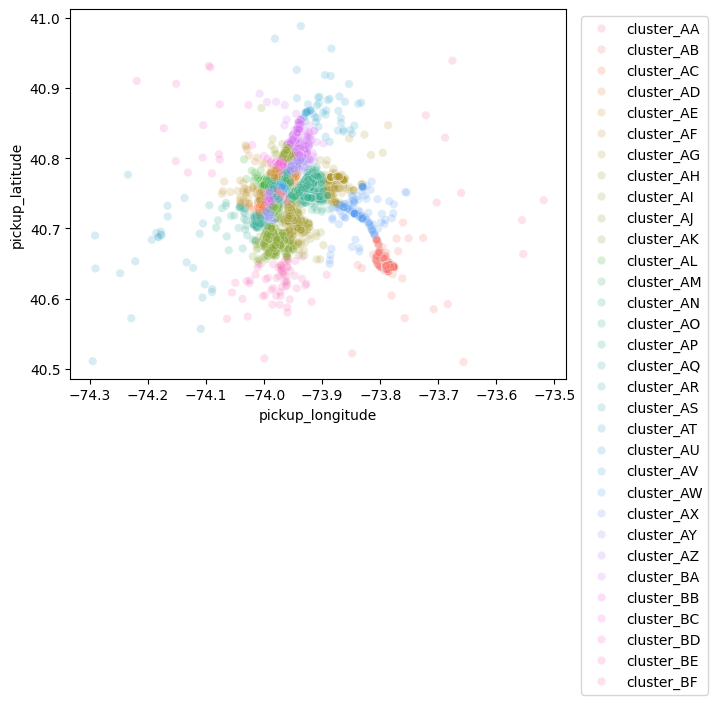

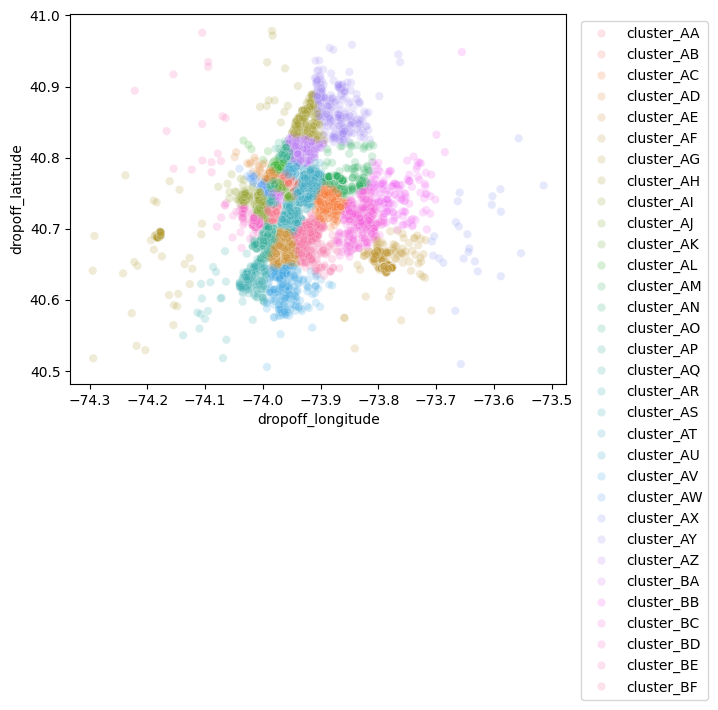

In [896]:
sns.scatterplot(data=taxi, x='pickup_longitude', y='pickup_latitude', hue='pickup_loc', alpha=0.2)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
plt.show(); plt.clf()

sns.scatterplot(data=taxi, x='dropoff_longitude', y='dropoff_latitude', hue='dropoff_loc', alpha=0.2)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))

### Airports

In [897]:
def jfk(df):
    return (df['pickup_longitude'].between(-73.7841, -73.7721) & df['pickup_latitude'].between(40.6213, 40.6613)) | (df['dropoff_longitude'].between(-73.7841, -73.7721) & df['dropoff_latitude'].between(40.6213, 40.6613))
def lga(df):
    return (df['pickup_longitude'].between(-73.8870, -73.8580) & df['pickup_latitude'].between(40.7680, 40.7800)) | (df['dropoff_longitude'].between(-73.8870, -73.8580) & df['dropoff_latitude'].between(40.7680, 40.7800))
def ewr(df):
    return (df['pickup_longitude'].between(-74.1920, -74.1720) & df['pickup_latitude'].between(40.6760, 40.7080)) | (df['dropoff_longitude'].between(-74.1920, -74.1720) & df['dropoff_latitude'].between(40.6760, 40.7080))

taxi['jfk'] = jfk(taxi)
taxi['lga'] = lga(taxi)
taxi['ewr'] = ewr(taxi)

In [898]:
m = folium.Map(location=(40.7, -74.0))
folium.Marker(location=(40.642, -73.779), icon=folium.Icon(icon='plane', prefix='fa')).add_to(m)
folium.Marker(location=(40.776, -73.874), icon=folium.Icon(icon='plane', prefix='fa')).add_to(m)
folium.Marker(location=(40.691, -74.178), icon=folium.Icon(icon='plane', prefix='fa')).add_to(m)
# taxi.loc[taxi['jfk_pu']].apply(lambda r:folium.Marker(location=(r['pickup_latitude'], r['pickup_longitude'])).add_to(m), axis=1)

display(m)

### Direction

In [899]:
def bearing(lat1, lon1, lat2, lon2):
    dlon = lon2 - lon1
    
    x = np.cos(np.radians(lat2)) * np.sin(np.radians(dlon))
    y = np.cos(np.radians(lat1)) * np.sin(np.radians(lat2)) - np.sin(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.cos(np.radians(dlon))
    bearing_rad = np.arctan2(x, y)
    
    bearing_deg = np.degrees(bearing_rad)
    return bearing_deg

def direction(df):
    return round(bearing(df['pickup_latitude'], df['pickup_longitude'], df['dropoff_latitude'], df['dropoff_longitude']))

taxi['direction'] = direction(taxi)

### OSM Distance

In [900]:
G = ox.graph_from_place('Manhattan, NY, USA', network_type='drive')
G = ox.add_edge_speeds(G)
G = ox.add_edge_travel_times(G)

G = nx.relabel.convert_node_labels_to_integers(G)
G_ig = ig.Graph.from_networkx(G)

In [901]:
def get_osm_nodes(df):
    p_nodes, p_nodes_dist = ox.nearest_nodes(G, Y=df['pickup_latitude'], X=df['pickup_longitude'], return_dist=True)
    d_nodes, d_nodes_dist = ox.nearest_nodes(G, Y=df['dropoff_latitude'], X=df['dropoff_longitude'], return_dist=True)
    return p_nodes, d_nodes, p_nodes_dist, d_nodes_dist

def get_osm_distances(p_nodes, d_nodes, mask):
    distances = np.empty(len(p_nodes))
    for i in range(len(p_nodes)):
        if mask[i]:
            dist = G_ig.distances(p_nodes[i], d_nodes[i], weights='length')[0][0]
            if (dist == 0) | (dist == np.inf):
                print(f'Row {i}: {dist}', end='  ')
                distances[i] = np.NaN
            else:
                distances[i] = dist
        else:
            distances[i] = np.NaN
    distances = (distances / 1000)
    return distances

def get_osm_travel_times(p_nodes, d_nodes, mask):
    travel_times = np.empty(len(p_nodes))
    for i in range(len(p_nodes)):
        if mask[i]:
            t_time = G_ig.distances(p_nodes[i], d_nodes[i], weights='travel_time')[0][0]
            if (t_time == 0) | (t_time == np.inf):
                print(f'Row {i}: {t_time}', end='  ')
                travel_times[i] = np.NaN
            else:
                travel_times[i] = t_time
        else:
            travel_times[i] = np.NaN
    return travel_times

def osm_metric(df, metric='distances'):
    p_nodes, d_nodes, p_nodes_dist, d_nodes_dist = get_osm_nodes(df)
    
    mask = np.where(((np.array(p_nodes_dist) < 100) & (np.array(d_nodes_dist) < 100)), True, False)   # Distance in m

    if metric == 'distances': 
        distances = get_osm_distances(p_nodes, d_nodes, mask)
        return distances
    elif metric == 'travel_times':
        travel_times = get_osm_travel_times(p_nodes, d_nodes, mask)
        return travel_times
    elif metric == 'both':
        distances = get_osm_distances(p_nodes, d_nodes, mask)
        travel_times = get_osm_travel_times(p_nodes, d_nodes, mask)
        return distances, travel_times
    else:
        raise Exception('Invalid metric choice...')

def update_distance(df):
    osm_distances = osm_metric(df, metric='distances')
    print(f'\nNaN percent: {round((pd.Series(osm_distances).isna().sum()) * 100 / len(osm_distances), 2)}%')

    return np.where(~np.isnan(osm_distances), osm_distances, df['distance_km'])



## Visualisations

### Fare vs Distance

<Axes: xlabel='distance_km', ylabel='fare_amount'>

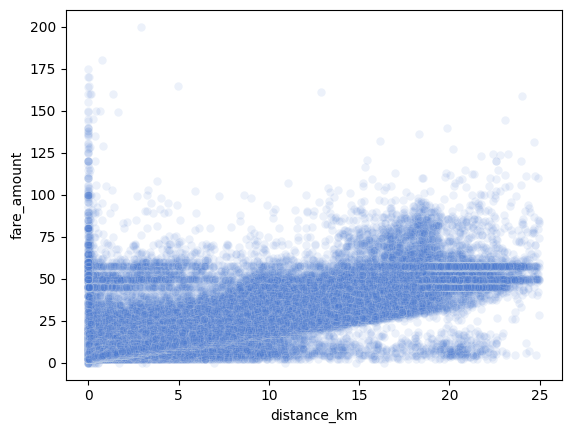

In [234]:
sns.scatterplot(data=taxi.loc[taxi['distance_km'] <= 25], x='distance_km', y='fare_amount', alpha=0.1)

In [235]:
# sns.lmplot(data=taxi.loc[taxi['distance_km'] <= 25], x='distance_km', y='fare_amount', hue='passenger_count', scatter_kws={'alpha':0.1})

### Fare vs Passengers

<Axes: xlabel='passenger_count', ylabel='count'>

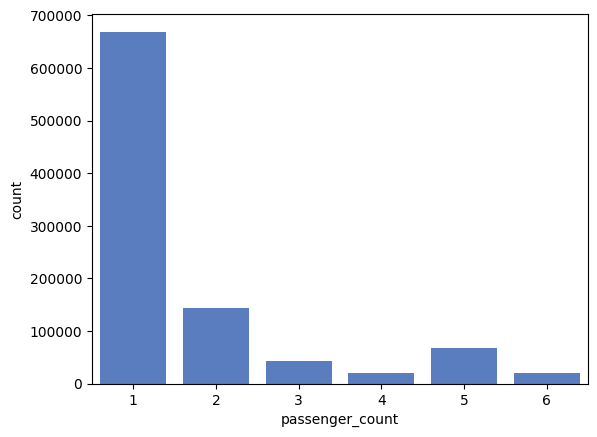

In [236]:
sns.countplot(data=taxi, x='passenger_count')

<Axes: xlabel='passenger_count', ylabel='fare_amount'>

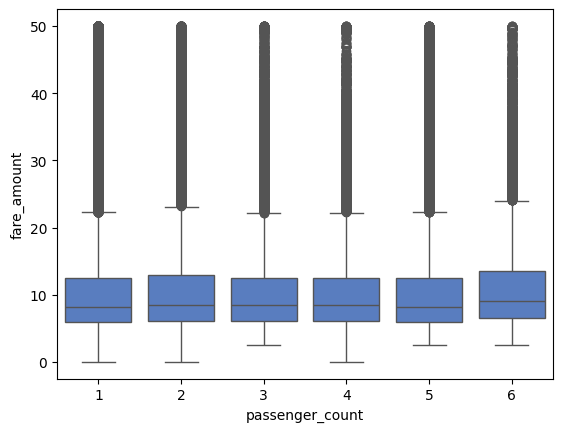

In [237]:
sns.boxplot(data=taxi.loc[taxi['fare_amount'] <= 50], x='passenger_count', y='fare_amount')

<Axes: xlabel='multiple_passengers', ylabel='fare_amount'>

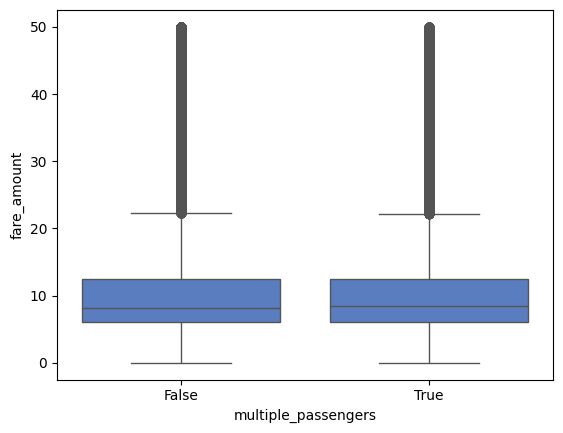

In [238]:
taxi_pass_red = taxi.copy()
taxi_pass_red['multiple_passengers'] = np.where(taxi_pass_red['passenger_count'] > 1, True, False)

sns.boxplot(data=taxi_pass_red.loc[taxi_pass_red['fare_amount'] <= 50], x='multiple_passengers', y='fare_amount')

In [239]:
# sns.lmplot(data=taxi_pass_red.loc[taxi_pass_red['distance_km'] <= 25], x='distance_km', y='fare_amount', hue='multiple_passengers', scatter_kws={'alpha':0.02})

### Fare vs Time

#### Fare vs Pickup Hour

Text(0.5, 1.0, 'Fare vs Hour')

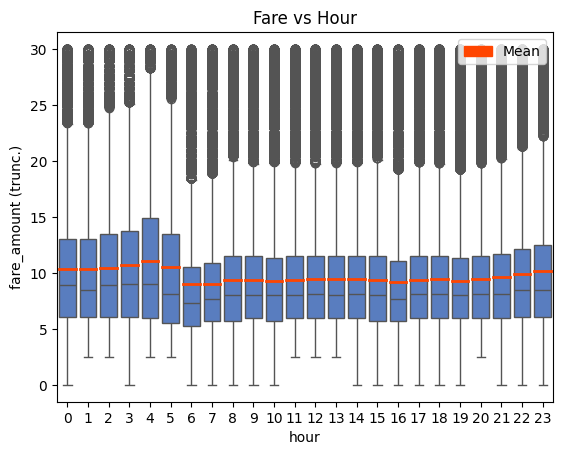

In [240]:
fare_hour_box = sns.boxplot(data=taxi.loc[taxi['fare_amount'] <= 30], x='hour', y='fare_amount', showmeans=True, meanline=True, meanprops={'linestyle':'-', 'linewidth':2, 'color':'orangered'})
fare_hour_box.set_ylabel(f'{fare_hour_box.get_ylabel()} (trunc.)')
plt.legend(handles=[mpatches.Patch(color='orangered', label='Mean')], loc='upper right')
plt.title('Fare vs Hour')

#### Fare vs Pickup Day of Week

Text(0.5, 1.0, 'Fare vs Day of Week')

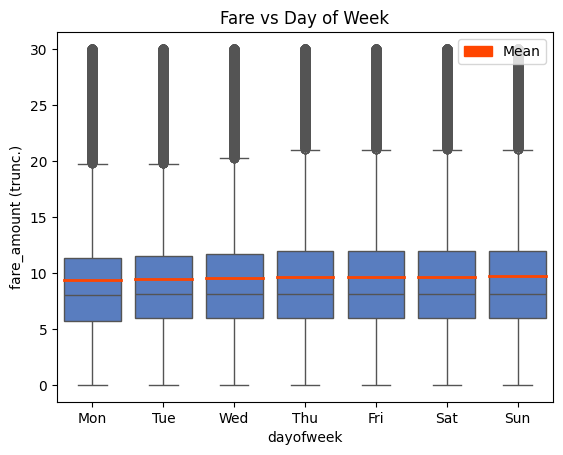

In [241]:
fare_dayofweek_box = sns.boxplot(data=taxi.loc[taxi['fare_amount'] <= 30], x='dayofweek', y='fare_amount', order=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], showmeans=True, meanline=True, meanprops={'linestyle':'-', 'linewidth':2, 'color':'orangered'})
fare_dayofweek_box.set_ylabel(f'{fare_dayofweek_box.get_ylabel()} (trunc.)')
plt.legend(handles=[mpatches.Patch(color='orangered', label='Mean')], loc='upper right')
plt.title('Fare vs Day of Week')

#### Fare vs Pickup Month

Text(0.5, 1.0, 'Fare vs Month')

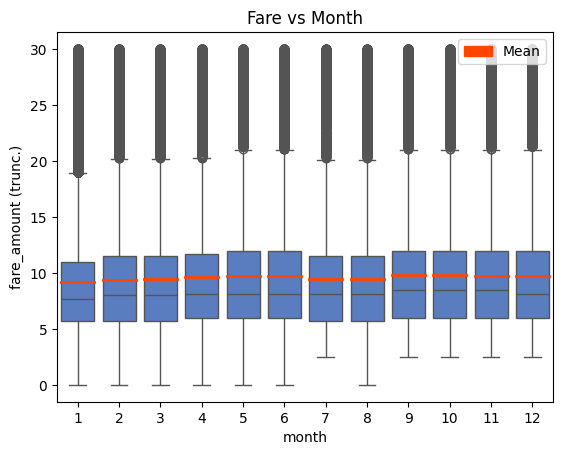

In [242]:
fare_month_box = sns.boxplot(data=taxi.loc[taxi['fare_amount'] <= 30], x='month', y='fare_amount', showmeans=True, meanline=True, meanprops={'linestyle':'-', 'linewidth':2, 'color':'orangered'})
fare_month_box.set_ylabel(f'{fare_month_box.get_ylabel()} (trunc.)')
plt.legend(handles=[mpatches.Patch(color='orangered', label='Mean')], loc='upper right')
plt.title('Fare vs Month')

#### Fare vs Pickup Year

Text(0.5, 1.0, 'Fare vs Year')

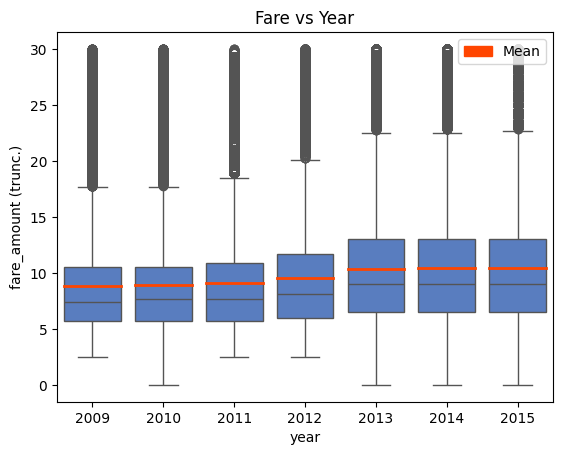

In [243]:
fare_year_box = sns.boxplot(data=taxi.loc[taxi['fare_amount'] <= 30], x='year', y='fare_amount', showmeans=True, meanline=True, meanprops={'linestyle':'-', 'linewidth':2, 'color':'orangered'})
fare_year_box.set_ylabel(f'{fare_year_box.get_ylabel()} (trunc.)')
plt.legend(handles=[mpatches.Patch(color='orangered', label='Mean')], loc='upper right')
plt.title('Fare vs Year')

#### Fare vs Pickup Day of Week and Hour

<Axes: xlabel='dayofweek', ylabel='hour'>

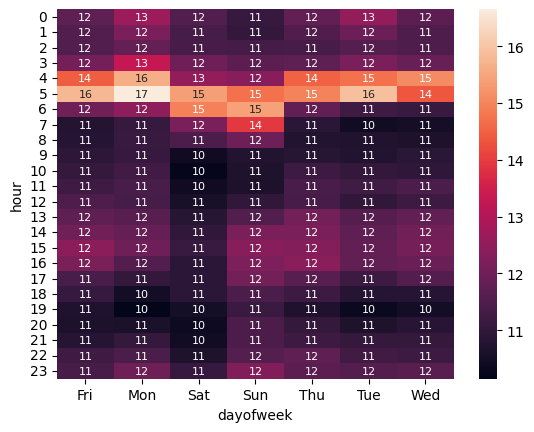

In [244]:
fare_dayofweek_hour = taxi.groupby(['dayofweek', 'hour'])['fare_amount'].mean().reset_index()
fare_dayofweek_hour = fare_dayofweek_hour.pivot(index='hour', columns='dayofweek', values='fare_amount')

sns.heatmap(data=fare_dayofweek_hour, annot=True, annot_kws={'size':8})

### Location

In [245]:
# sns.scatterplot(data=taxi.loc[taxi['fare_amount'] <= 50], x='dropoff_longitude', y='dropoff_latitude', hue='fare_amount', alpha=0.5)

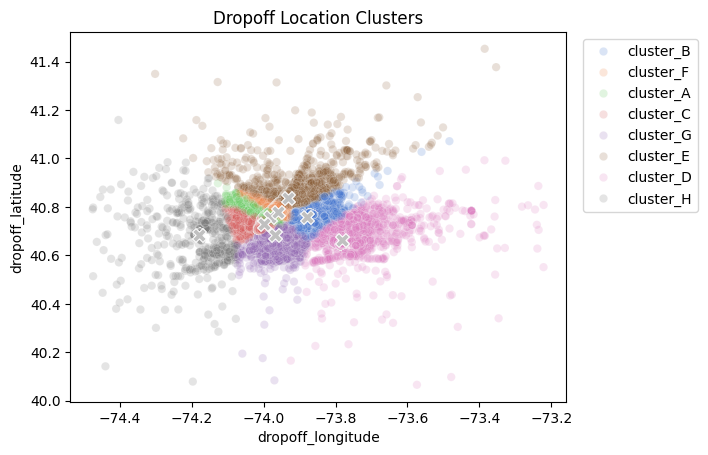

In [246]:
dropoff_locs = taxi[['dropoff_longitude', 'dropoff_latitude']]
# scaler = StandardScaler()
# scaled_dropoff_locs = scaler.fit_transform(dropoff_locs)

kmeans = KMeans(n_clusters=8, n_init=10)
kmeans.fit(dropoff_locs)

clust_name_dict = {i:f'cluster_{c}' for i,c in enumerate(ascii_uppercase)}
kmeans_clusters = pd.Series(kmeans.labels_).replace(clust_name_dict)
kmeans_centroids = pd.DataFrame(kmeans.cluster_centers_).rename(columns={0:'dropoff_longitude', 1:'dropoff_latitude'}, index=clust_name_dict)

sns.scatterplot(data=taxi, x='dropoff_longitude', y='dropoff_latitude', hue=kmeans_clusters, alpha=0.2)
sns.scatterplot(data=kmeans_centroids, x='dropoff_longitude', y='dropoff_latitude', s=100, c='silver', marker='X')
plt.title('Dropoff Location Clusters')
plt.legend(loc='upper right', bbox_to_anchor=(1.28, 1))

In [247]:
kmeans_cluster_fares = pd.DataFrame()
kmeans_cluster_fares['count'] = taxi.groupby(kmeans_clusters)['key'].count()
kmeans_cluster_fares['mean'] = taxi.groupby(kmeans_clusters)['fare_amount'].mean()
kmeans_cluster_fares['mean_diff'] = kmeans_cluster_fares['mean'] - taxi['fare_amount'].mean()
kmeans_cluster_fares['summed_diff'] = kmeans_cluster_fares['count'] * abs(kmeans_cluster_fares['mean_diff'])
print(kmeans_cluster_fares['summed_diff'].sum()/len(taxi))
kmeans_cluster_fares.head(len(kmeans_cluster_fares))

2.7064868378338787


,count,mean,mean_diff,summed_diff
cluster_A,387641,9.700317,-1.630273,631960.602064
cluster_B,29727,23.904141,12.573551,373773.938472
cluster_C,255988,10.081497,-1.249093,319752.885290
cluster_D,10995,40.945087,29.614497,325611.391989
cluster_E,20507,19.905443,8.574853,175844.509078
cluster_F,213043,9.670910,-1.659680,353583.163987
cluster_G,44914,18.847878,7.517288,337631.456815
cluster_H,1754,64.030336,52.699746,92435.354987


### Direction

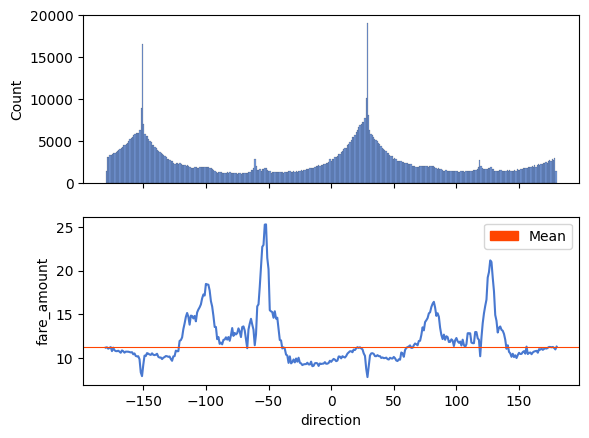

In [248]:
fig, axs = plt.subplots(2, 1, sharex=True)

direction_round = round(taxi['direction'])
sns.histplot(ax=axs[0], data=direction_round, bins=361)

direction_fare_group = taxi.groupby(direction_round)['fare_amount'].mean()
sns.lineplot(ax=axs[1], data=direction_fare_group)
plt.axhline(y=taxi['fare_amount'].mean(), color='orangered', linewidth=0.8)
plt.legend(handles=[mpatches.Patch(color='orangered', label='Mean')], loc='upper right')

### OSM Distance

5.671613000000002
4.155444291845812


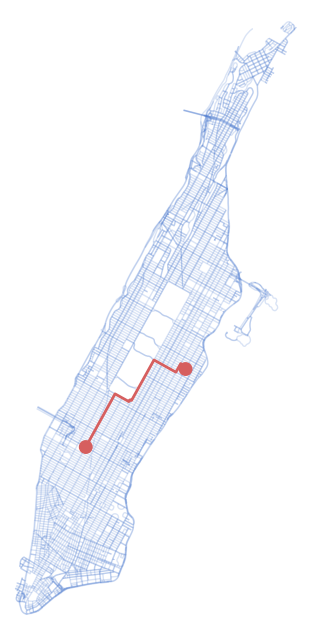

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [193]:
row = 7
pickup_node = ox.nearest_nodes(G, Y=taxi.iloc[row]['pickup_latitude'], X=taxi.iloc[row]['pickup_longitude'])
dropoff_node = ox.nearest_nodes(G, Y=taxi.iloc[row]['dropoff_latitude'], X=taxi.iloc[row]['dropoff_longitude'])

shortest_route = ox.shortest_path(G, pickup_node, dropoff_node, weight='length')

print(nx.shortest_path_length(G, pickup_node, dropoff_node, weight='length') / 1000)
print(taxi.iloc[row]['distance_km'])

display(ox.plot_graph_route(G=G, route=shortest_route, route_color=pal[3], route_linewidth=2, route_alpha=1, edge_color=pal[0], edge_alpha=0.2, bgcolor='w', node_size=0))

## Feature Selection

In [902]:
y = taxi['fare_amount']

num_features = ['distance_km', 'direction', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']
cat_features = ['nighttime', 'jfk', 'lga', 'ewr']
cat_ohe_features = ['hour', 'month', 'year', 'pickup_loc', 'dropoff_loc']

features_list = num_features + cat_features + cat_ohe_features

X_cat = taxi[features_list]
X = pd.get_dummies(X_cat, columns=cat_ohe_features)
cat_labels = [f for f in X if f.startswith(tuple(cat_features + cat_ohe_features))]

## Modelling

In [250]:
test_size_vals = [0.01, 0.1, 0.2]
results_dict = {}

repeats = 10
aggr_RMSE_list = [0 for _ in range(repeats)]

# model = LinearRegression()
model = HistGradientBoostingRegressor(max_leaf_nodes=20, categorical_features=cat_labels)
for test_size_val in test_size_vals:
    for repeat in range(repeats):
        train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=test_size_val, random_state=repeat)
        model.fit(train_X, train_y)
        pred_y = model.predict(val_X)
        aggr_RMSE_list[repeat] = mean_squared_error(val_y, pred_y, squared=False)
    aggr_RMSE = (sum(aggr_RMSE_list)/repeats)
    results_dict[test_size_val] = round(aggr_RMSE, 4)

results = pd.Series(results_dict)
print(f"Mean RMSE: {results.mean():.4f}")
print(results)

Mean RMSE: 3.4909
0.01    3.4598
0.10    3.4968
0.20    3.5160
dtype: float64


In [254]:
# model = HistGradientBoostingRegressor(categorical_features=cat_labels)
# params ={'max_iter':[100, 150, 200], 'max_leaf_nodes':[31, 20, 25], 'max_depth':[None, 8, 10, 12]}
# gs_cv = GridSearchCV(model, params, verbose=1)
# gs_cv.fit(X, y)
# pd.DataFrame(gs_cv.cv_results_).sort_values(by='rank_test_score')

## Final Model and Predictions

In [863]:
model = HistGradientBoostingRegressor(max_leaf_nodes=20, categorical_features=cat_labels, random_state=0)
model.fit(X, y)

HistGradientBoostingRegressor(categorical_features=['nighttime', 'jfk', 'lga',
                                                    'ewr', 'hour_0', 'hour_1',
                                                    'hour_2', 'hour_3',
                                                    'hour_4', 'hour_5',
                                                    'hour_6', 'hour_7',
                                                    'hour_8', 'hour_9',
                                                    'hour_10', 'hour_11',
                                                    'hour_12', 'hour_13',
                                                    'hour_14', 'hour_15',
                                                    'hour_16', 'hour_17',
                                                    'hour_18', 'hour_19',
                                                    'hour_20', 'hour_21',
                                                    'hour_22', 'hour_23',
                                                    'month_1', 'month_2', ...],
                              max_leaf_nodes=20, random_state=0)

In [864]:
test = pd.read_csv('test.csv')

test['pickup_datetime'] = pd.to_datetime(test['pickup_datetime'])
test['distance_km'] = distance_km(test)
test['hour'] = hour(test)
test['dayofweek'] = dayofweek(test)
test['month'] = month(test)
test['year'] = year(test)
test['nighttime'] = nighttime(test)
test['multiple_passengers'] = multiple_passengers(test)
test['pickup_loc'] = pickup_loc(test)
test['dropoff_loc'] = dropoff_loc(test)
# test['distance_loc'] = distance_loc(test)
test['jfk'] = jfk(test)
test['lga'] = lga(test)
test['ewr'] = ewr(test)
test['direction'] = direction(test)

In [865]:
test_X_cat = test[features_list]
test_X = pd.get_dummies(test_X_cat, columns=cat_ohe_features)

test_preds = model.predict(test_X)

## Submission

In [866]:
output = pd.DataFrame({'key': test['key'], 'fare_amount': test_preds})
output.to_csv('submission.csv', index=False)